In [2]:
%reload_ext autoreload
%autoreload 2
from sklearn.calibration import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy import stats
from common import load_data, baseline_results_wc
from sklearn.metrics import classification_report
from sklearn.preprocessing import scale


In [3]:
# Data Loading
random_state = 1234
test_size = 0.40
pareto_cutoff = 0.5
rank_by_domination_count = True
system = "x264"

performances = []
# performances = ["fps", "cpu"]
# performances = ["kbs", "fps"]
# performances = ["kbs", "etime"]

(
    perf_matrix_initial,
    input_features,
    config_features,
    all_performances,
    input_preprocessor,
    config_preprocessor,
) = load_data(system=system, data_dir="../data", input_properties_type="tabular")

if len(performances) == 0:
    performances = all_performances

nmdf = (
    perf_matrix_initial[["inputname"] + performances]
    .groupby("inputname", as_index=True)
    .transform(lambda x: scale(x))
    # .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
)
nmdf["worst_case_performance"] = nmdf[performances].max(axis=1)
perf_matrix = pd.merge(
    perf_matrix_initial, nmdf, suffixes=("_raw", None), left_index=True, right_index=True
)
perf_matrix["rank"] = perf_matrix.groupby("inputname", group_keys=False).apply(
    lambda x: x["worst_case_performance"].argsort()+1
)
# We adjust the WCP by expressing it as the difference from the best WCP, i.e. the best WCP is always 0
perf_matrix["worst_case_performance"] = (
    perf_matrix[["inputname", "worst_case_performance"]]
    .groupby("inputname", as_index=True)
    .transform(lambda x: x - x.min())
)

all_perf_raw = [f"{p}_raw" for p in performances]
all_perf_norm = [f"{p}" for p in performances]



# Split data
train_inp, test_inp = train_test_split(
    perf_matrix["inputname"].unique(),
    test_size=test_size,
    random_state=random_state,
)

# This is only to make our evaluation simpler
train_inp = sorted(train_inp)
test_inp = sorted(test_inp)

# Prepare baseline evaluation
icm = (
    perf_matrix[perf_matrix.inputname.isin(train_inp)][["inputname", "configurationID", "worst_case_performance"]]
    .sort_values(["inputname", "configurationID"])
    .set_index(["inputname", "configurationID"])
)
icm_ranked_measures = icm.groupby(
    "inputname"
).transform(  # Go from measured values to ranks within each input group
    lambda x: x.argsort()+1
)
icm["ranks"] = icm.groupby("inputname", group_keys=False).apply(
    lambda x: x["worst_case_performance"].argsort()+1
)


icm_test = (
    perf_matrix[~perf_matrix.inputname.isin(train_inp)][["inputname", "configurationID", "worst_case_performance"]]
    .sort_values(["inputname", "configurationID"])
    .set_index(["inputname", "configurationID"])
)
icm_test["ranks"] = icm_test.groupby("inputname", group_keys=False).apply(
    lambda x: x["worst_case_performance"].argsort()+1
)

# Full dataset of input features + config features that are in the first rank
dataset_baselines = icm.join(config_features).join(input_features).reset_index()

def eval_prediction(pred_cfg_test):
    inp_pred_map = pd.DataFrame(
        zip(test_inp, pred_cfg_test), columns=["inputname", "configurationID"]
    )
    return icm_test.merge(inp_pred_map, on=["inputname", "configurationID"])["worst_case_performance"].mean()


/tmp/ipykernel_59289/3593637404.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  perf_matrix["rank"] = perf_matrix.groupby("inputname", group_keys=False).apply(


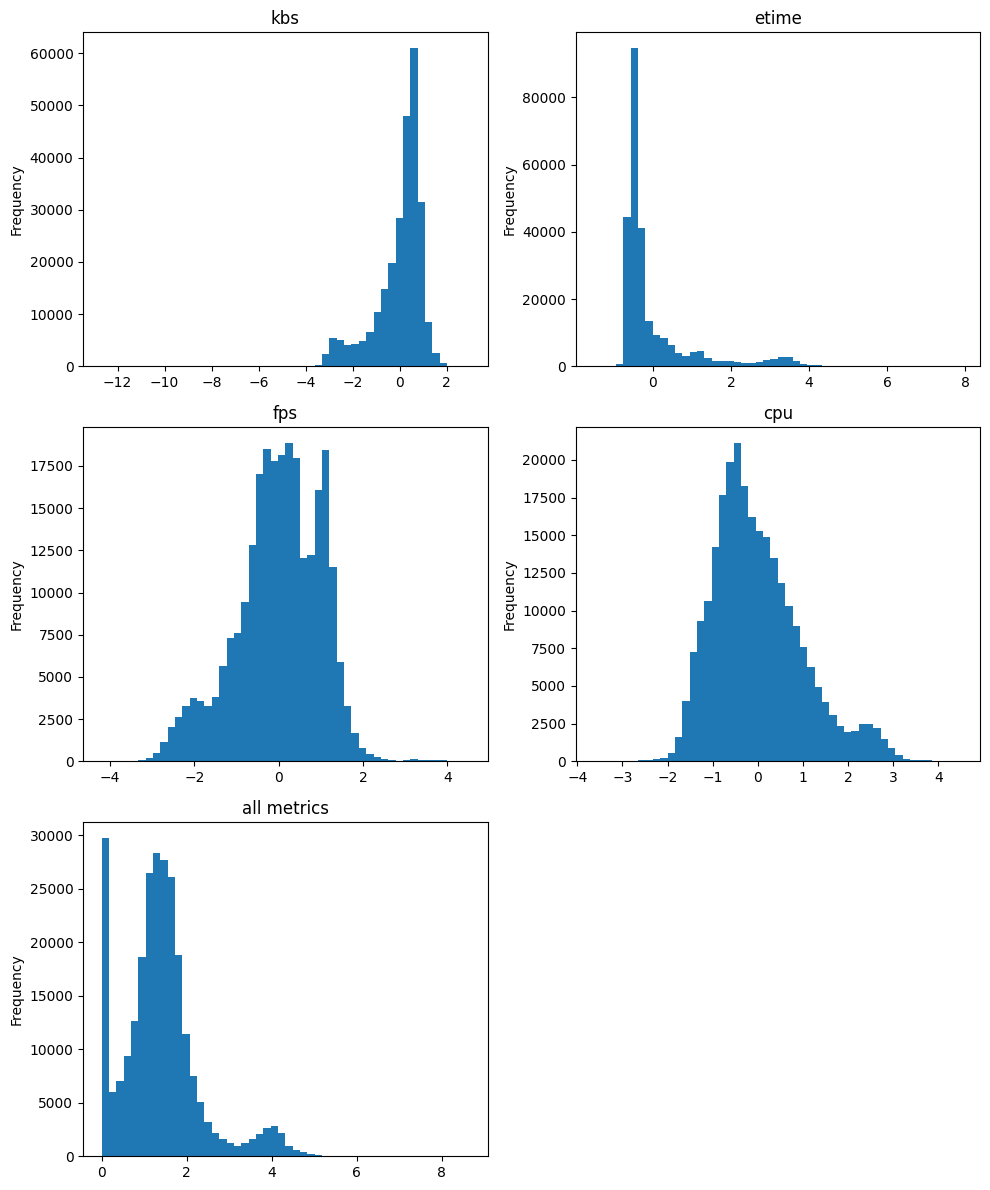

In [5]:
# Calculate number of columns and rows needed
metrics = performances + ["worst_case_performance"]
n = len(metrics)
rows = int(np.ceil(n/2))
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(10, 4*rows))
axes = axes.flatten()

for i, c in enumerate(metrics):
    perf_matrix[c].plot.hist(bins=50, ax=axes[i])
    if c == "worst_case_performance":
        axes[i].set_title("all metrics")
    else:
        axes[i].set_title(c)

# Hide any empty subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

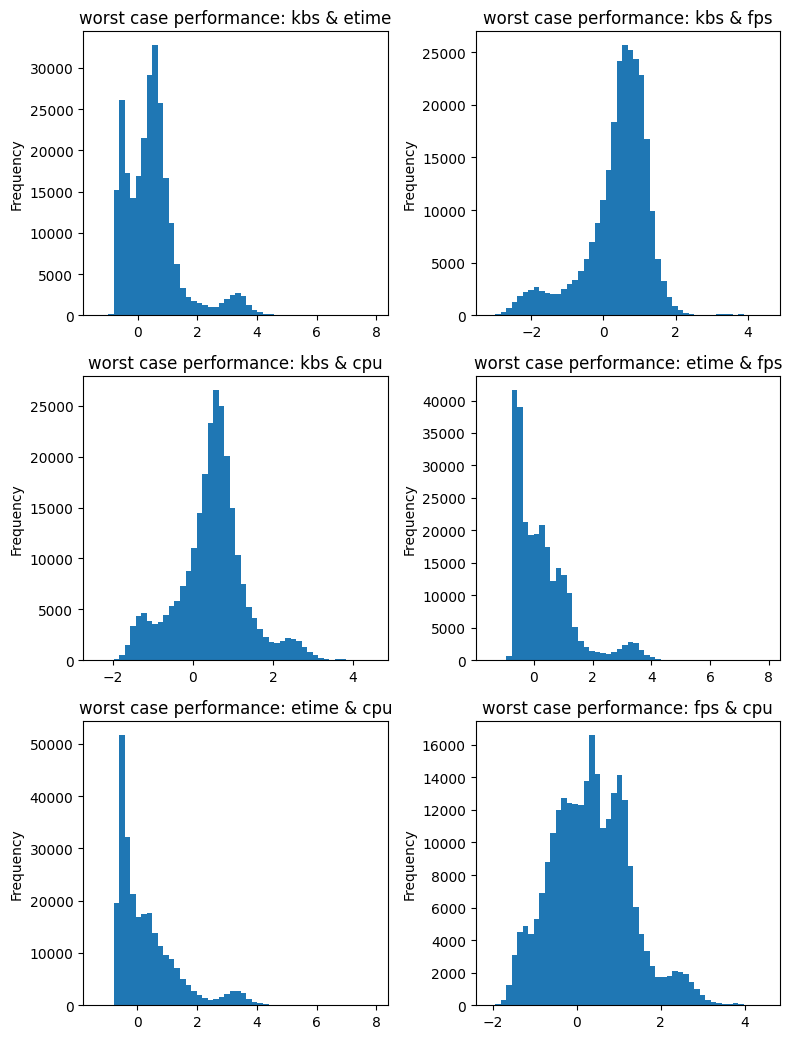

In [4]:
# Calculate number of combinations for subplot grid
combs = list(itertools.combinations(performances, 2))
n = len(combs)
rows = int(np.ceil(np.sqrt(n)))
cols = int(np.ceil(n/rows))

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3.5*rows))
axes = axes.flatten()

for i, (c1, c2) in enumerate(combs):
    perf_matrix[[c1, c2]].max(axis=1).plot.hist(bins=50, ax=axes[i])
    axes[i].set_title(f"worst case performance: {c1} & {c2}")

# Hide any empty subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [5]:
# Baseline preparation


baseline_results_wc(icm, icm_ranked_measures, icm_test, dataset_baselines, config_features, verbose=True)

Best WCP per input: 0.00+-0.00 (with 22 configs)
Average WCP per input: 1.38+-0.09
Average WCP of the overall best configuration: 0.03+-0.09
Average WCP of the most common configuration: 0.04+-0.10
Average WCP of the best configuration for all metrics: 0.43+-0.40


{'best': [np.float64(0.0), np.float64(0.0)],
 'best_num_configs': 22,
 'average': [np.float64(1.383675704313129), np.float64(0.08739949054223266)],
 'overall': [np.float64(0.02964331528538111), np.float64(0.08946643470526827)],
 'metric': [np.float64(0.4343582964603245), np.float64(0.402654002842692)],
 'common': [np.float64(0.04046708090868479), np.float64(0.10208852781991803)]}

shapes (772, 21) (772,) (515, 21) (515,)


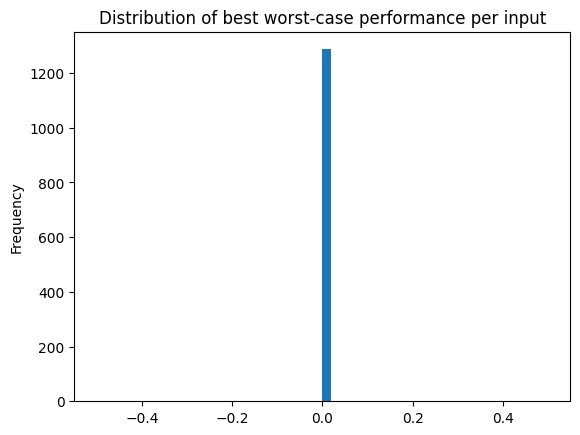

In [6]:
# Single configuration dataset
# We find the best configuration per input
dataset = (
    perf_matrix.groupby('inputname')
    .apply(lambda x: x.loc[x['worst_case_performance'].idxmin()], include_groups=False)
    .reset_index()
)

train_perf = dataset[dataset.inputname.isin(train_inp)].copy()
test_perf = dataset[dataset.inputname.isin(test_inp)]

X = input_preprocessor.fit_transform(
    train_perf[
        input_features.columns
    ]
)
y = train_perf["configurationID"]

X_test = input_preprocessor.transform(
    test_perf[  
        input_features.columns
    ]
)
y_test = test_perf["configurationID"]
print("shapes", X.shape, y.shape, X_test.shape, y_test.shape)

# This is the best worst-case performance per input
dataset.worst_case_performance.plot.hist(bins=50)
plt.title("Distribution of best worst-case performance per input")
plt.show()

In [7]:
clf = RandomForestClassifier(n_estimators=10, random_state=random_state)
clf.fit(X, y)
print("scores", clf.score(X, y), clf.score(X_test, y_test))
pred_cfg_test = clf.predict(X_test)

print(
    f"Avg. WCP on test inputs {eval_prediction(pred_cfg_test):.2f}"
    )
print(classification_report(y_test, clf.predict(X_test)))


scores 0.9857512953367875 0.10485436893203884
Avg. WCP on test inputs 0.04
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        26
          11       0.00      0.00      0.00         4
          13       0.21      0.28      0.24        78
          14       0.06      0.09      0.07        47
          15       0.13      0.09      0.11        66
          16       0.04      0.06      0.05        32
          17       0.12      0.18      0.14        34
          18       0.00      0.00      0.00         8
          19       0.15      0.13      0.14        15
          20       0.13      0.16      0.14        43
          22       0.00      0.00      0.00         9
          23       0.00      0.00      0.00         8
          24       0.00      0.00      0.00        35
          25       0.08      0.04      0.06        23
          28       0.00      0.00      0.00         7
          29       0.00      0.00      0.00         3
      

/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

In [8]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(8,8,8,), max_iter=1000,random_state=random_state)
clf.fit(X, y)
print("scores", clf.score(X, y), clf.score(X_test, y_test))
pred_cfg_test = clf.predict(X_test)

print(
    f"Avg. WCP on test inputs {eval_prediction(pred_cfg_test):.2f}"
    )
print(classification_report(y_test, clf.predict(X_test)))


scores 0.13730569948186527 0.1378640776699029
Avg. WCP on test inputs 0.03
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        26
          11       0.00      0.00      0.00         4
          13       0.17      0.77      0.28        78
          14       0.09      0.02      0.03        47
          15       0.19      0.06      0.09        66
          16       0.00      0.00      0.00        32
          17       0.00      0.00      0.00        34
          18       0.00      0.00      0.00         8
          19       0.00      0.00      0.00        15
          20       0.05      0.14      0.07        43
          22       0.00      0.00      0.00         9
          23       0.00      0.00      0.00         8
          24       0.00      0.00      0.00        35
          25       0.00      0.00      0.00        23
          28       0.00      0.00      0.00         7
          29       0.00      0.00      0.00         3
      

/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
clf = LogisticRegression(max_iter=1_000, dual=True, solver="liblinear")

scaler = StandardScaler()
X2 = scaler.fit_transform(X)
X_test2 = scaler.transform(X_test)
clf.fit(X2, y)
print("scores", clf.score(X2, y), clf.score(X_test2, y_test))
pred_cfg_test = clf.predict(X_test2)

print(
    f"Avg. WCP on test inputs {eval_prediction(pred_cfg_test):.2f}"
    )
print(classification_report(y_test, clf.predict(X_test2)))


scores 0.39248704663212436 0.34951456310679613
Avg. WCP on test inputs 0.04
              precision    recall  f1-score   support

           1       0.39      0.23      0.29        64
          13       0.33      0.06      0.10        17
          14       0.00      0.00      0.00        19
          15       0.00      0.00      0.00        15
          16       1.00      0.05      0.10        19
          17       0.00      0.00      0.00         7
          18       0.00      0.00      0.00         6
          20       0.00      0.00      0.00         9
          21       0.54      0.30      0.39        23
          22       0.36      0.23      0.28        60
          24       0.00      0.00      0.00         9
          25       0.00      0.00      0.00        18
          28       0.00      0.00      0.00         6
          29       0.00      0.00      0.00        20
          30       0.00      0.00      0.00         1
          31       0.37      0.75      0.49       136
     

/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [9]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=random_state)
clf.fit(X, y)
pred_cfg_test = clf.predict(X_test)
print(clf.score(X, y), clf.score(X_test, y_test))
print("Avg. WCP", eval_prediction(pred_cfg_test))
print(classification_report(y_test, clf.predict(X_test)))

1.0 0.09514563106796116
Avg. WCP 0.04629849170309152
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        26
          11       0.00      0.00      0.00         4
          13       0.25      0.18      0.21        78
          14       0.06      0.06      0.06        47
          15       0.10      0.08      0.08        66
          16       0.14      0.16      0.15        32
          17       0.08      0.15      0.11        34
          18       0.00      0.00      0.00         8
          19       0.00      0.00      0.00        15
          20       0.07      0.09      0.08        43
          22       0.00      0.00      0.00         9
          23       0.20      0.25      0.22         8
          24       0.11      0.14      0.12        35
          25       0.04      0.04      0.04        23
          28       0.00      0.00      0.00         7
          29       0.00      0.00      0.00         3
          30       0.00     

/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

In [10]:
for depth in range(1, 20):
    clf = DecisionTreeClassifier(random_state=random_state, max_depth=depth)
    clf.fit(X, y)
    pred_cfg_test = clf.predict(X_test)
    print(f"WCP@{depth}: {eval_prediction(pred_cfg_test):.3f}")

WCP@1: 0.029
WCP@2: 0.029
WCP@3: 0.031
WCP@4: 0.031
WCP@5: 0.030
WCP@6: 0.030
WCP@7: 0.030
WCP@8: 0.030
WCP@9: 0.035
WCP@10: 0.037
WCP@11: 0.036
WCP@12: 0.037
WCP@13: 0.040
WCP@14: 0.052
WCP@15: 0.053
WCP@16: 0.051
WCP@17: 0.048
WCP@18: 0.047
WCP@19: 0.048


In [11]:
clf2 = DecisionTreeClassifier(random_state=random_state, max_depth=None)
clf2.fit(X, y)

pred_cfg_test = clf2.predict(X)
print(f"WCP: {eval_prediction(pred_cfg_test):.3f}", clf2.score(X, y))
print(classification_report(y, clf2.predict(X)))

pred_cfg_test = clf2.predict(X_test)
print(f"WCP: {eval_prediction(pred_cfg_test):.3f}", clf2.score(X_test, y_test))
print(classification_report(y_test, clf2.predict(X_test)))

WCP: 0.042 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        32
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00        92
          14       1.00      1.00      1.00        73
          15       1.00      1.00      1.00        74
          16       1.00      1.00      1.00        72
          17       1.00      1.00      1.00        68
          18       1.00      1.00      1.00         6
          19       1.00      1.00      1.00        27
          20       1.00      1.00      1.00        74
          22       1.00      1.00      1.00         9
          23       1.00      1.00      1.00         9
          24       1.00      1.00      1.00        57
          25       1.00      1.00      1.00        49
          28       1.00      1.00      1.00         2
          29       1.00      1.00      1.00         1
          30

/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

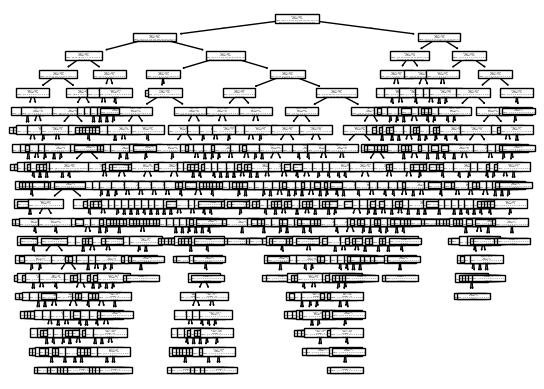

In [13]:
from sklearn import tree
tree.plot_tree(clf)
plt.show()


In [11]:
## Multiple configurations per input

# The threshold must be at least this high to include all inputs
min_wc_perf_threshold = perf_matrix[["inputname", "worst_case_performance"]].groupby("inputname").min().max().item()
wc_perf_threshold = 0.30


# worse_inputs = perf_matrix[perf_matrix["worst_case_performance"] >= wc_perf_threshold]["inputname"]
# # TODO Fix such that for missing inputs, we take the next best configuration (even if it's above the threshold)

# assert wc_perf_threshold >= min_wc_perf_threshold, "wc_perf_threshold not high enough"

# TODO We don't need this encoder, but we need something for the apply function in the dataset_below groupby
enc = LabelEncoder()
enc.fit(perf_matrix["configurationID"].tolist())

# This is the largest minimal WCP over all inputs
# If we set a general threshold it must be at least this high, otherwise we exclude inputs
min_wc_perf_threshold = perf_matrix[["inputname", "worst_case_performance"]].groupby("inputname").min().max().item()
wc_perf_threshold = 0.03

is_below_threshold = perf_matrix[perf_matrix["worst_case_performance"] < wc_perf_threshold].inputname.unique()
all_above_threshold = set(perf_matrix[perf_matrix["worst_case_performance"] >= wc_perf_threshold].inputname.unique()) - set(is_below_threshold)

# We find the best configurations per input
dataset_below = (
    perf_matrix[perf_matrix["worst_case_performance"] < wc_perf_threshold].groupby('inputname')["configurationID"].apply(enc.transform)
)
dataset_above = (
    perf_matrix[perf_matrix.inputname.isin(all_above_threshold)].groupby('inputname')
    .apply(lambda x: x.loc[x['worst_case_performance'].idxmin()], include_groups=False)["configurationID"].apply(lambda x: [x])
)

# (index/inputname, configurationIDs)
dataset = pd.concat((dataset_above, dataset_below)).sort_index().reset_index()



# num_cfg_per_input = 5  # alternative, but less useful?
# dataset = perf_matrix[perf_matrix.worst_case_performance < wc_perf_threshold]
# print(dataset.shape, dataset.inputname.nunique()/perf_matrix.inputname.nunique())
# enc = LabelEncoder()
# enc.fit(perf_matrix["configurationID"].tolist())
# # We find the best configurations per input
# dataset = (
#     perf_matrix.groupby('inputname')["configurationID"].apply(enc.transform).reset_index()
# )

train_perf = dataset[dataset.inputname.isin(train_inp)].copy()
test_perf = dataset[dataset.inputname.isin(test_inp)]

In [12]:
# wc_perf_mask = perf_matrix["worst_case_performance"] < wc_perf_threshold

# enc = LabelEncoder()
# enc.fit(perf_matrix[wc_perf_mask]["configurationID"].tolist())

# grouped_df = perf_matrix[wc_perf_mask].groupby("inputname")["configurationID"].apply(enc.transform).reset_index()
grouped_df = dataset
grouped_df

,inputname,configurationID
0,Animation_1080P-01b3,[31]
1,Animation_1080P-05f8,"[20, 30]"
2,Animation_1080P-0c4f,"[0, 12, 13, 14, 15, 16, 19, 23, 24, 27, 28, 30..."
3,Animation_1080P-0cdf,"[20, 27]"
4,Animation_1080P-18f5,[20]
...,...,...
1282,Vlog_720P-561e,"[0, 12, 13, 14, 15, 16, 19, 23, 24, 28, 30, 31]"
1283,Vlog_720P-5d08,[20]
1284,Vlog_720P-60f8,[20]
1285,Vlog_720P-6410,"[21, 32]"


<Axes: ylabel='Frequency'>

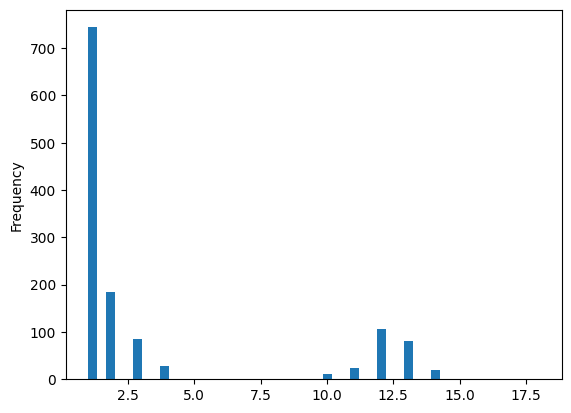

In [13]:
grouped_df["configurationID"].apply(len).plot.hist(bins=50)

In [14]:
input_features_with_cfgs = grouped_df.join(input_features, on="inputname")

train_mask = input_features_with_cfgs.inputname.isin(train_inp)

X_train = input_preprocessor.fit_transform(
    input_features_with_cfgs[train_mask][input_features.columns]
)
X_test = input_preprocessor.transform(
    input_features_with_cfgs[~train_mask][input_features.columns]
)

In [15]:
from common import DecisionTreeClassifierWithMultipleLabels

mlb = MultiLabelBinarizer()
binary_matrix = mlb.fit_transform(grouped_df["configurationID"])

# Create a new DataFrame with the binary matrix
binary_df = pd.DataFrame(
    binary_matrix, columns=mlb.classes_, index=grouped_df["inputname"]
)
y_train = binary_df.values[train_mask]
y_test = binary_df.values[~train_mask]

clf = DecisionTreeClassifierWithMultipleLabels(max_depth=X.shape[1])
clf.fit(X_train, y_train)
print("scores", clf.score(X_train, y_train), clf.score(X_test, y_test))
pred_cfg_test = enc.inverse_transform(clf.predict(X_test)).astype(int)
print(f"WCP {eval_prediction(pred_cfg_test)}")

scores 1.0 0.6077669902912621
WCP 0.4399156008005741


In [16]:
binary_df

,0,10,11,12,13,14,15,16,17,19,...,33,51,52,59,89,90,99,100,105,106
inputname,,,,,,,,,,,,,,,,,,,,,
Animation_1080P-01b3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Animation_1080P-05f8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Animation_1080P-0c4f,1,0,0,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
Animation_1080P-0cdf,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Animation_1080P-18f5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vlog_720P-561e,1,0,0,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
Vlog_720P-5d08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Vlog_720P-60f8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# TODO Evaluate decision tree size: it should be smaller for a larger wcp threshold
# TODO Change decision tree training to optimize
# TODO What's the best performance the configurations from the training set can achieve? / helps our internal evaluation of the method
# TODO How many configurations with very similar WCPs are there for the different inputs? -> make plot? heatmap, x input, y intensity per WCP bin
# TODO Statistical test vs best result (or all others?) / is it significantly higher?
# TODO Should we express the WCP as a percentage of the best WCP, e.g. MAPE over best possible WCP? That is, normalize WCP per input.

In [18]:
perf_matrix.groupby("inputname")["worst_case_performance"].agg(lambda x: (x < 0.05).sum()).max()

18

In [19]:
all_performances

['kbs', 'etime', 'fps', 'cpu']

In [20]:
import itertools
ap = []
for num_p in range(1, len(all_performances) + 1):
    ap.extend(list(map(list, itertools.combinations(all_performances, num_p))))

ap

[['kbs'],
 ['etime'],
 ['fps'],
 ['cpu'],
 ['kbs', 'etime'],
 ['kbs', 'fps'],
 ['kbs', 'cpu'],
 ['etime', 'fps'],
 ['etime', 'cpu'],
 ['fps', 'cpu'],
 ['kbs', 'etime', 'fps'],
 ['kbs', 'etime', 'cpu'],
 ['kbs', 'fps', 'cpu'],
 ['etime', 'fps', 'cpu'],
 ['kbs', 'etime', 'fps', 'cpu']]